## DenseNet（稠密连接网络）
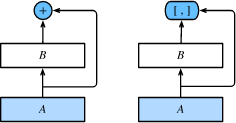

In [1]:
import torch
from torch import nn
import dltools


def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [22]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            print(blk)
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

In [23]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

Sequential(
  (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ReLU()
  (2): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Sequential(
  (0): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ReLU()
  (2): Conv2d(13, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


torch.Size([4, 23, 8, 8])

In [4]:
# 过渡层
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [5]:
# DenseNet模型
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [10]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [17]:
# dense_block → transition_block → dense_block → transition_block
blks

[DenseBlock(
   (net): Sequential(
     (0): Sequential(
       (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (1): ReLU()
       (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     )
     (1): Sequential(
       (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (1): ReLU()
       (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     )
     (2): Sequential(
       (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (1): ReLU()
       (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     )
     (3): Sequential(
       (0): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (1): ReLU()
       (2): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     )
   )
 ),
 Sequential(
   (0): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, trac

In [11]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

In [ ]:
# 模型训练
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = dltools.load_data_fashion_mnist(batch_size, resize=96)
dltools.train_ch6(net, train_iter, test_iter, num_epochs, lr, dltools.try_gpu())

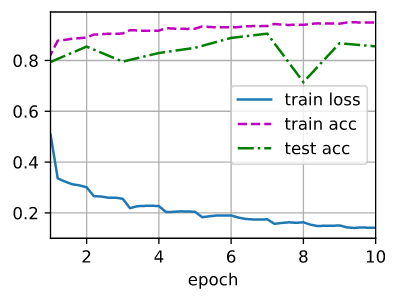